**# Ejemplo de Árbol de decisión**

In [134]:
######################
# adquirir datos
######################

import pandas as pd
datos = pd.read_csv("data/diabetes.csv") # dataframe

# Voy a categorizar en funcion de los casos sin diabetes (casos negativos)
casos_negativos = datos.sort_values(by='Outcome')
cantidad_casos_negativos = casos_negativos['Outcome'].value_counts(sort=False,ascending=True)[0]
casos_negativos = casos_negativos[:cantidad_casos_negativos]
# print(casos_negativos)

In [135]:
import numpy as np
# Indagacion de los datos
# Analizo los datos en busca de ceros y faltantes
caracteristicas = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI','DiabetesPedigreeFunction']
cuenta = 0
for caract in caracteristicas:
    descriptor = datos[caract].describe()
    cuenta_de_valores = datos[caract].value_counts()
    cantidad_ceros = cuenta_de_valores[0] if 0 in cuenta_de_valores else 0
    cuenta += cantidad_ceros
    print(f'cantidad de ceros en {caract}: {cantidad_ceros}')
print(f'cuenta:{cuenta}')



cantidad de ceros en Glucose: 5
cantidad de ceros en BloodPressure: 35
cantidad de ceros en SkinThickness: 227
cantidad de ceros en Insulin: 374
cantidad de ceros en BMI: 11
cantidad de ceros en DiabetesPedigreeFunction: 0
cuenta:652


Dado que existe una cantidad significativa de ceros, y considerando que 
representan que no se midió, los paso a NaN para que no sean considerados 
en los promedios y algunos calculos

In [136]:
# Asumo que los valores nulos de `caracteristicas` no fueron medidos y los convierto a NaN
# print(datos['Glucose'].describe())
for caract in caracteristicas:
    descriptor = casos_negativos[caract].describe()
    datos[caract] = datos[caract].replace([0, 0.0], np.NaN)
    casos_negativos[caract] = casos_negativos[caract].replace([0, 0.0, '0'], np.NaN)

# print(datos['Glucose'].describe())

In [137]:
datos = datos.dropna().reset_index()
# print(datos)

In [138]:
# Pre-procesamiento de datos. Categorizacion de 'Age'
def mapearEdades(edad):
    if (edad >= 0 and edad <= 11): return 0 # 'niño'
    elif (edad >= 12 and edad <= 18): return 1 # 'adolescente'
    elif (edad >= 19 and edad <= 25): return 2 # 'joven'
    elif (edad >= 26 and edad <= 59): return 3 # 'adulto'
    elif (edad >= 60 and edad <= 70): return 4 # 'mayor'
    
datos['Age'] = datos['Age'].apply(mapearEdades)

In [139]:
# Pre-procesamiento de datos. Categorizacion de 'Glucose'
# IMPORTANTE: Categorizo en función de los casos SIN diabetes
descriptor = casos_negativos['Glucose'].describe()

intervalos_glucosa_segun_promedio = [
    descriptor['min'], 
    descriptor['mean'] - descriptor['std'], 
    descriptor['mean'] + descriptor['std'], 
    descriptor['max']
    ]
etiquetas_glucosa = [0, 1, 2]

datos['Glucose'] = pd.cut(datos['Glucose'], bins=intervalos_glucosa_segun_promedio, labels=etiquetas_glucosa)
# print(datos)

In [140]:
# Categorizo el resto de las caracteristicas segun el bloque anterior
caracteristicas_restantes = ['BloodPressure', 'SkinThickness', 'BMI', 'DiabetesPedigreeFunction', 'Insulin']

for caract in caracteristicas_restantes:
    descriptor = casos_negativos[caract].describe()
    # print(descriptor)
    intervalos = [
        descriptor['min'], 
        descriptor['mean'] - descriptor['std'], 
        descriptor['mean'] + descriptor['std'], 
        descriptor['max']
        ]
    etiquetas = [0, 1, 2]

    datos[caract] = pd.cut(datos[caract], bins=intervalos, labels=etiquetas)
    # print(datos)


In [141]:
# print(datos)

In [142]:
# Falta generar categorizacion en funcion de cuartiles

In [143]:
# IMPORTANTE: Falta normalizar

### Splitting de datos

In [144]:
# Splitting de datos

from sklearn.model_selection import train_test_split

caracteristicas_entrada = [
    # 'Pregnancies', 
    'Glucose',
    'BloodPressure', 
    'SkinThickness', 
    'BMI', 
    'DiabetesPedigreeFunction', 
    'Insulin',
    'Age']
caracteristicas_objetivo = 'Outcome'

X_train, X_test, y_train, y_test = train_test_split(
    datos[caracteristicas_entrada],
    datos[caracteristicas_objetivo],
    test_size = 0.3
    )

In [145]:
from unittest import mock
from sklearn import tree
import sklearn

arbol_segun_media = tree.DecisionTreeClassifier(criterion='entropy')
with mock.patch("sklearn.utils.validation._assert_all_finite"):
    arbol_segun_media.fit(X=X_train, y=y_train)

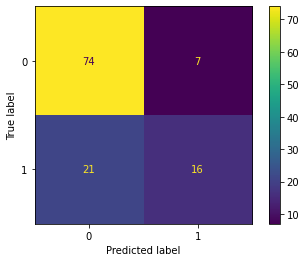

In [146]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

# Analizar modelo
predicciones = []
with mock.patch("sklearn.utils.validation._assert_all_finite"):
    predicciones = arbol_segun_media.predict(X=X_test)
matriz_confusion = confusion_matrix(y_true=y_test, y_pred=predicciones)
widget_matriz_confusion = ConfusionMatrixDisplay(
    confusion_matrix=matriz_confusion, 
    display_labels=arbol_segun_media.classes_
    )
widget_matriz_confusion.plot()
plt.show()

In [147]:
print(X_train)

    Glucose BloodPressure SkinThickness BMI DiabetesPedigreeFunction Insulin  \
30        2             2             1   1                        1       1   
115       2             2             1   1                        1       1   
110       2             1             2   1                        2       2   
381       1             0             1   1                        1       1   
382       2             2             1   2                        2       1   
..      ...           ...           ...  ..                      ...     ...   
389       1             0             1   1                        2       0   
248       1             1             2   2                        1       2   
151       2             1             0   1                        1       1   
130       1             1             1   1                        1       1   
24        2             1             2   1                        1       2   

     Age  
30   3.0  
115  3.0  
110  3